In [1]:
import numpy as np
import pickle
import utils
import matplotlib.pyplot as plt

import textwrap

### The Problem:

You've been hired by an eccentric bike company as an AI engineer to help with their prototyping software. For your probationary assignment, the company has asked for a tool to help their designers visualize design concepts. They want to provide a partial image, some design parameters that they have selected for the design, and a marketing prompt. Your job is to use your AI magic to create an image of the completed design concept. 

Your manager has "thrown you off the deep end," and isn't the best at answering your questions. For example, since you have no idea how to interpret the designers' jargon, you have no idea what each parameter is referring to on the bike! A lot of the bikes also look very strange or even physically infeasible and nobody seems to be able to explain why. Seems like they *really* want to explore the design space...

Fortunately the company has provided a set of 10,000 previous design concepts (these designers stay busy!). These previous design concepts include the complete image, partial image, design parameters and marketing pitches. This gives you some hope to train a generative model! 

For your probationary assessment, the company has also provided 1,000 test designs to evaluate (partial image, parameters, and marketing pitch), but has not provided the completed images. They want you to use your "AI magic" to predict the complete designs and they will evaluate how accurately you were able to do so. Your job is on the line! How accurately can you predict these design concepts?

### Exploring The Data

We have prepared a helper function to load up the data. Let's call that function and take a look at the different components of our data

In [2]:
partial_images, masks, parametric, description, targets = utils.load_data()

In [3]:
print(f"Masked images: array with shape: {partial_images.shape}")
print(f"Masks: array with shape: {masks.shape}")
print(f"Parametric: array with shape: {parametric.shape}")
print(f"Description: list with length: {len(description)}")
print(f"Images: array with shape: {targets.shape}")

Masked images: array with shape: (10000, 3, 80, 128)
Masks: array with shape: (10000, 4)
Parametric: array with shape: (10000, 96)
Description: list with length: 10000
Images: array with shape: (10000, 3, 80, 128)


Let's have a look at the first entry of the parametric data. We can see that we have a few specified parametric values that aren't labeled in any way. the rest of the values are nans.  

In [30]:
parametric[0]

array([           nan,            nan,            nan, 6.20937007e+01,
       1.31141113e+02,            nan,            nan,            nan,
       7.63218804e+02, 5.96530067e+01,            nan, 3.11535683e+01,
                  nan,            nan, 1.10350907e+01, 1.04152904e+01,
                  nan,            nan, 5.12534557e+01,            nan,
                  nan,            nan, 1.35300393e+01, 1.44887388e-01,
       3.44191730e-01, 1.36933498e+02, 2.00000000e+00,            nan,
                  nan, 9.00000000e-01,            nan, 1.00000000e+00,
                  nan, 4.96935219e+02, 6.12624222e+01, 4.83649049e+02,
                  nan,            nan, 5.63796245e+02,            nan,
       7.45982037e+01, 5.25287944e+01,            nan, 3.46312256e+01,
       6.44946992e-01, 6.67663753e-01,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 6.76637626e+01,            nan,
      

Ok, now let's take a look at the complete images, masked images and the marketing descriptions:

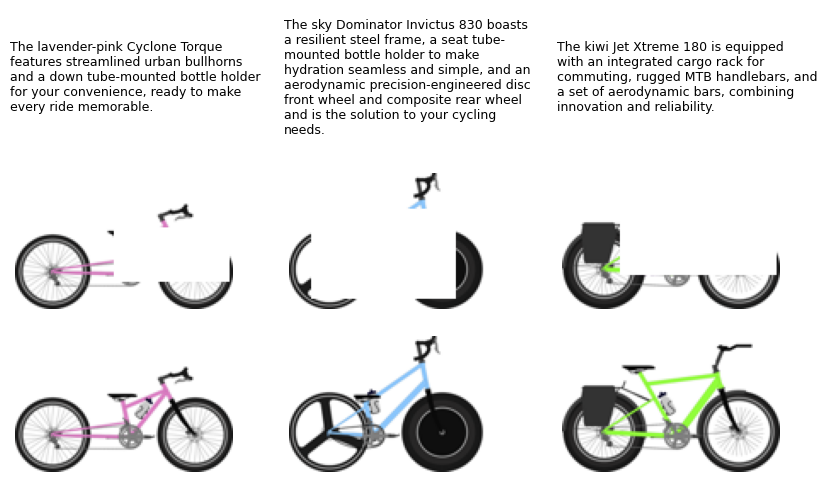

In [5]:
# Visualize 5 masked and complete images side by side
fig, ax = plt.subplots(3, 3, figsize=(10, 6))
random_3 = np.random.choice(range(len(description)), 3, replace=False)

for i in range(3):
    idx = random_3[i]
    wrapped_text = "\n".join(textwrap.wrap(description[idx], width=37))  
    ax[0, i].text(0, 0.5, wrapped_text, fontsize=9, va='center')  # Use va='center' and adjust y position
    partial_im = np.moveaxis(partial_images[idx], 0, -1)
    im = np.moveaxis(targets[idx], 0, -1)
    ax[1, i].imshow(partial_im)
    ax[2, i].imshow(im)
    
    # Turn off axes
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[2, i].axis("off")

plt.show()


In case there is any ambiguity about the mask locations, these are provided too. Let's take a look at the mask information for these three bikes. The mask information contains the indices of the edges of the mask (order: left, bottom, right, top). Remember that we count pixels from top to bottom when dealing with numpy arrays.

In [6]:
masks[random_3]

array([[ 58,  64, 126,  32],
       [ 13,  74,  98,  21],
       [ 34,  60, 126,   4]])

### Starter Code

**How do we fill in the mask of a partial image??**

One strategy is to create a VAE that is trained to reconstruct a full image even if we have a partial encoding. To help the VAE identify masked portions of images during training, we can give it an extra feature that segments where an image is masked.

In the function *add_mask_channel()*, a fourth channel is created that passes the value 1 where the *NaN* mask is present in the image. This way, each image has 4 channels: Red, Green, Blue, and Mask.  For our full images, this fourth channel is all zeros. 

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW

from torchsummary import summary

from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def get_mask_channel(images, masks):
    # Create an empty mask channel with the same spatial dimensions
    mask_channel = np.zeros((images.shape[0], images.shape[2], images.shape[3]))
    
    # Populate the mask channel based on the coordinates in masks
    for i in trange(masks.shape[0]):
        mask_channel[i, masks[i][3]:masks[i][1], masks[i][0]:masks[i][2]] = 1.0

    return mask_channel

# Scale the images for machine learning
def scale_images(images):
    images = images / 255.0 
    return images

#return the image to RGB format
def to_rgb(images):
    img = images * 255
    return img.astype(np.uint8)

        

In [9]:
processed_partial_images = scale_images(partial_images)
processed_targets = scale_images(targets)

mask_channel = get_mask_channel(processed_partial_images, masks)[:, None, :, :]
processed_partial_images = np.concatenate([processed_partial_images, mask_channel], axis=1)

print(processed_partial_images.shape)
print(processed_targets.shape)


100%|██████████| 10000/10000 [00:01<00:00, 8191.23it/s]


(10000, 4, 80, 128)
(10000, 3, 80, 128)


In [10]:
# Convert the numpy arrays to PyTorch tensors
processed_partial_images = torch.tensor(processed_partial_images, dtype=torch.float32)
processed_targets = torch.tensor(processed_targets, dtype=torch.float32)

# Test-Train split
train_masked, val_masked, train_targets, val_targets = train_test_split(processed_partial_images, processed_targets, test_size=0.1, random_state=42)

# Create a DataLoader
train_masked = train_masked.to(device)
train_targets = train_targets.to(device)

train_data = TensorDataset(train_masked, train_targets)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)



In [11]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 8, 128)  # Output for both mean and variance layers

        # Separate layers for mean and variance
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        # Compute mean and variance
        mu = self.fc_mean(x)
        logvar = self.fc_var(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Fully connected layers to expand the latent space
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 64 * 5 * 8)

        # Upsampling and transpose convolution layers
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv3 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv4 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, 5, 8)

        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = self.upconv4(x)  # Sigmoid for output in range [0, 1]
        return x
    
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_net = Encoder(latent_dim)
        self.decoder_net = Decoder(latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mu, logvar = self.encoder_net(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, x):
        return torch.sigmoid(self.decoder_net(x))

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        output = self.decode(z)
        return output, mu, logvar

    def show_summaries(self, input_size, batch_size=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_net.to(device)
        self.decoder_net.to(device)
        
        print("Encoder Summary:")
        summary(self.encoder_net, input_size=input_size, batch_size=batch_size, device=str(device))

        print("\nDecoder Summary:")
        summary(self.decoder_net, input_size=(self.latent_dim,), batch_size=batch_size, device=str(device))


def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD * 0.005


In [12]:
def train_vae_model(train_loader, model, optimizer,num_epochs, device):
  model = model.to(device)
  model.train()

  for epoch in range(num_epochs):
    logs = {}
    running_loss = 0.0
    prog = tqdm(enumerate(train_loader), total=len(train_loader))
    n = 0
    for batch_idx, (data, target) in prog:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      output, mu, logvar = model(data)
      loss = vae_loss(output, target, mu, logvar)
      loss.backward()
      optimizer.step()
      running_loss += loss.detach() * data.size(0)
      n += data.size(0)

      prog.set_description(f"Epoch {epoch+1}/{num_epochs}")
      prog.set_postfix_str(f"Loss: {loss.item():.7f} | Running Loss: {running_loss/n:.7f}")

    epoch_loss = running_loss / len(train_loader)
    logs['loss'] = epoch_loss.item()

def pred_image(model, image_val):
  model.eval()  # Set the model to evaluation mode
  eval_images = torch.tensor(image_val[:8]).to(device)
  pred_images = model.reconstruct(eval_images)
  return pred_images.detach().cpu().numpy()

In [13]:
model = VAE(latent_dim=128).to(device)
model.show_summaries(input_size=(4, 80, 128))

Encoder Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 8, 80, 128]             296
         MaxPool2d-2             [1, 8, 40, 64]               0
            Conv2d-3            [1, 16, 40, 64]           1,168
         MaxPool2d-4            [1, 16, 20, 32]               0
            Conv2d-5            [1, 32, 20, 32]           4,640
         MaxPool2d-6            [1, 32, 10, 16]               0
            Conv2d-7            [1, 64, 10, 16]          18,496
         MaxPool2d-8              [1, 64, 5, 8]               0
           Flatten-9                  [1, 2560]               0
           Linear-10                   [1, 128]         327,808
           Linear-11                   [1, 128]          16,512
           Linear-12                   [1, 128]          16,512
Total params: 385,432
Trainable params: 385,432
Non-trainable params: 0
--------------

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)

num_epochs = 200
train_vae_model(train_loader, model, optimizer, num_epochs, device)

Epoch 200/200: 100%|██████████| 141/141 [00:01<00:00, 105.57it/s, Loss: 0.0204275 | Running Loss: 0.0213484]


In [15]:
def combine_orig_and_pred(masked_images, predicted_images, masks):
    combination = predicted_images*masks + masked_images*(1-masks)
    return combination

In [31]:
val_masked_im = val_masked.detach().cpu().numpy()[:,:3,:,:]
val_mask_channel = val_masked.detach().cpu().numpy()[:,3:4,:,:]

# Get the reconstructed images
model.eval()
with torch.no_grad():
    recon_masked_images, _, _ = model(val_masked.clone().to(device))

recon_masked_images = recon_masked_images.detach().cpu().numpy()

combined_reconstructed_images = combine_orig_and_pred(val_masked_im, recon_masked_images, val_mask_channel)

final_reconstructions = to_rgb(combined_reconstructed_images)

img_ground_truth = to_rgb(val_targets.detach().cpu().numpy())

Now we display 3 random images to visualize our reconstruction results?

Masked images Reconstruction


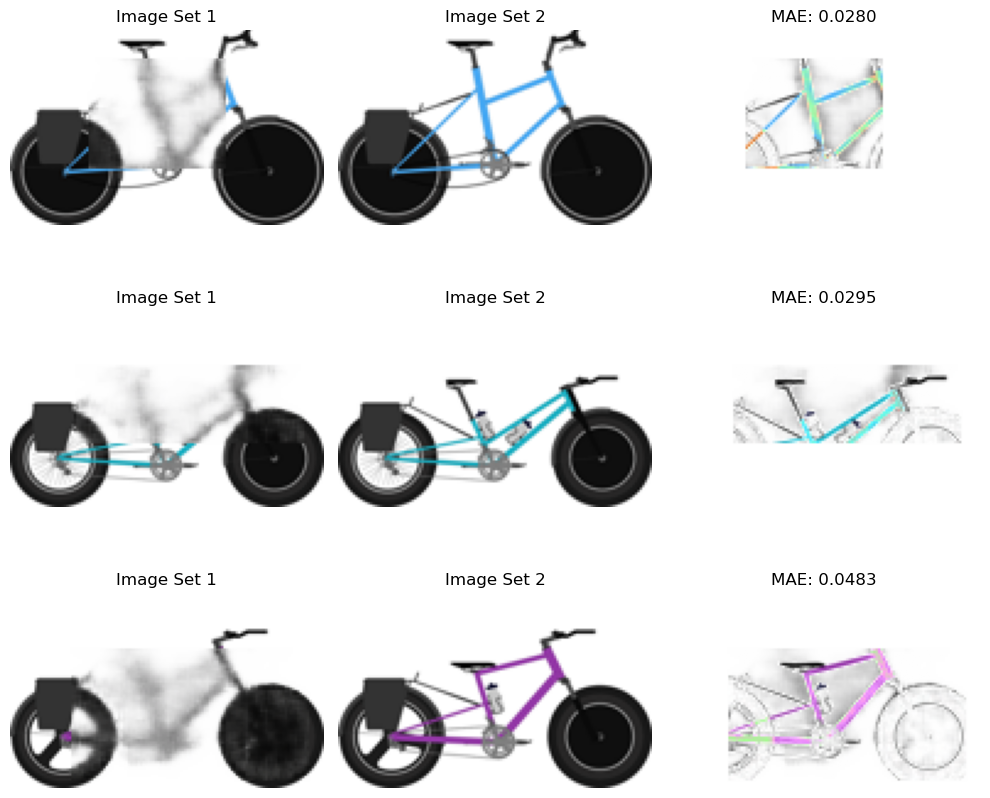

In [32]:
# Display random 3 images
random_3 = np.random.choice(range(len(final_reconstructions)), 3, replace=False)
print("Masked images Reconstruction")
utils.display_images_residual(final_reconstructions[random_3], img_ground_truth[random_3])

We can see that our VAE is very good at learning predictable features like the bike wheels when part of the wheel is unmasked. However, for some of the features that are difficult to deduce based on the rest of the bike, such as the frame, the VAE doesn't do a great job. This is also the case when an entire features (wheel, handles, cargo rack) are hidden. But can we expect it to correctly guess? Often times there isn't enough context to deduce the frame shape or the component types without the parametric or text information. This is where you can gain an advantage from the parametric or text data. But even without the additional information, there is clearly room for improvement. For example, even though the model can sometimes see the frame's color, it tensds to just guess on the color with a fuzzy gray. 

Let's calculate our composite score. This is the metric we will use to evaluate your submission. So if the validation set were the test set, this would be your submission score. Our composite score is a weighted combination of Mean Absolute Error and Structural Similarity Index Metric (SSIM). Exact reconstructions will earn a score of 1, while random noise will earn somewhere around a 0.5. The theoretical mimimum score is 0. 

In [18]:
mean_score, scores = utils.calculate_composite_score(final_reconstructions, img_ground_truth)
print(f"Mean Composite Score: {mean_score}")

c:\Users\jessi\miniforge3\envs\torch\Lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Mean Composite Score: 0.952328622341156


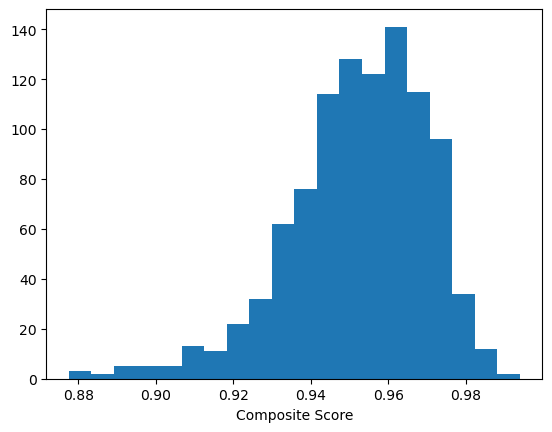

In [19]:
plt.hist(scores, bins=20)
plt.xlabel("Composite Score")
plt.show()

If we hadn't merged predictions with the non-masked regions:

In [20]:
print(f"Mean Composite Score: {utils.calculate_composite_score(to_rgb(recon_masked_images), img_ground_truth)[0]}")

Mean Composite Score: 0.912260115146637


If we just use the incomplete picture directly as our prediction for the complete picture:

In [21]:
print(f"Mean Composite Score: {utils.calculate_composite_score(to_rgb(masked_img_npy), img_ground_truth)[0]}")

Mean Composite Score: 0.9032465815544128


### How can I improve this model??

Your job is is create better sample images given the masked data. Some strategies that the TA's recommend trying are: 

1) Try another type of deep generative model, such as a Diffusion Model or a non-generative forward model, such as a U-net. Please ask the TA's for sample code or use the code from the demo! Diffusion models are the state of the art DGM for image synthesis and they will provide high quality images for this challenge problem. U-Nets are very strong models for image-image translation and editing. We highly recommend trying these approaches!

2) Create more masked images (you can create as many masked samples for each image in the training data as you want). The mask function is in the utils file. 

3) Utilize the masked parametric information or the text data to improve predictions. The are usually many possibilities for what may lie inside the masked areas. For a model to nail this prediction without more information is not only difficult but *impossible*. It is guessing! Take away some of the uncertainty using the parametric or text information. 

    a) To utilize the parametric data, you will have to deal with the nan values. For a basic strategy, you can perform imputation. For a more advanced strategy you can mask losses to only factor i the available data. 

    b) To utilize the text data, you need to find a text representation. A simple approach can use a word-frequency based "bag of words" approach to quantify the counts of certain key words. For a more advanced approach, we recommend using a pre-trained text embedding model to map each text string into a parametric vector. 

    c) Next, you need to add your parametric data or text representation to the model. Consult Demo 6 on multimodal learning to see how to implement hybrid neural networks. You will have to synthesize this knowledge with Demo 8 to implement a mixed-modality generative model.





### Prepare your Submission

In [22]:
masked_images_test, masks_test, parametric_test, description_test, _ = utils.load_data("test") # images_test is not provided. You need to predict image_test. 

In [23]:
masked_images_test = scale_images(masked_images_test)
mask_channel = get_mask_channel(masked_images_test, masks_test)[:, None, :, :]
masked_images_test = np.concatenate([masked_images_test, mask_channel], axis=1)
masked_images_test = torch.tensor(masked_images_test, dtype=torch.float32)
predictions = model(masked_images_test.to(device))[0].detach().cpu().numpy()

100%|██████████| 1000/1000 [00:00<00:00, 43480.96it/s]


Make sure your data is scaled correctly! We expect your images to be scaled from 0-255.

In [24]:
final_submission = to_rgb(predictions)

In [25]:
utils.validate_submission(final_submission)

Submission looks good!


In [26]:
id = utils.generate_random_id()
print(f"Saving submission as {id}.npy")
np.save(f"{id}.npy", final_submission)

Saving submission as 4860_7149_8450.npy
